## Caso de Uso: Pronóstico de la demanda de productos de Mayor Impacto, mediante de análisis Series Temporales. Suero de Helado.

**_Descripción_**

El presente estudio corresponde al Análisis de los datos de un negocio real de un Bar-Restaurant especializado en Hamburguesas. Los datos se encuentran comprendidos entre julio del 2023 y febrero del 2025.  La información proviene directamente del sistema contable utilizado por el propio negocio y corresponde además a uno de los locales.

Este Análisis es continuidad del estudio previo realizado en el notebook __**tfm_eda_notebook_Jorge_Arce**__.

**_Objetivo General_:**

El presente trabajo tiene como objetivo general, la predicción de las ventas  futuras por categorías más demandadas que podría tener el negocio.


**_Objetivos Específicos_:**
 - Modelar mediante análisis de Series Temporales el pronóstico de las ventas futuras de las categorías más demandadas.
 - Validar el modelo seleccionado.

 __NOTA: El análisis se realizará sobre el data set obtenido en la etapa de preprocesamiento y eda, por lo cual se prescindirá de este apartado, pasando directamente al análisis exploratorio de las series temporales asociados a las categorías de productos.__

#### **Carga Inicial:**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go 

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import STL
import pymannkendall as mk
from scipy.stats import kruskal
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet.diagnostics import cross_validation, performance_metrics
import itertools


#### **1. Recopilación de Datos**

***1.1. Carga Inicial de Datos:***

In [3]:
df_hystoric = pd.read_parquet('../data-sets/data_hitorico_ventas_mod.parquet')
df_hystoric.head(3)

,operacion,fecha,mercancia,grupo_mercancia,nombre_socio,cantidad,medida,precio_venta,importe,suma_total,dia_semana,tipo_dia,nombre_festivo,es_fin_semana,es_festivo
0,4593,2023-07-04 12:07:00,Cigarro H.Upman Con filtro,CIGARROS,Cliente2,1.0,U,190.0,190.0,190.0,Martes,Laborable,No Festivo,0,0
1,4598,2023-07-04 12:27:00,Espagueti de Jamon,PASTAS,Cliente2,2.0,U,549.0,1098.0,1098.0,Martes,Laborable,No Festivo,0,0
2,4598,2023-07-04 12:27:00,Termo Pack,INSUMOS VENTA,Cliente2,2.0,U,30.0,60.0,60.0,Martes,Laborable,No Festivo,0,0


In [4]:
df_day = pd.read_csv('../data-sets/dias_laborables_festivos_cuba.csv', encoding='utf-8')

#### **2. Limpieza y procesamiento de datos:**

**2.1. Análisis del tipo de datos de las variables.**

In [5]:
df_hystoric.dtypes

operacion                   int64
fecha              datetime64[ns]
mercancia                  object
grupo_mercancia            object
nombre_socio               object
cantidad                  float64
medida                     object
precio_venta              float64
importe                   float64
suma_total                float64
dia_semana                 object
tipo_dia                   object
nombre_festivo             object
es_fin_semana               int32
es_festivo                  int32
dtype: object

Resultados:
- Al ser un fichero en formato parquet, se cargan las variables con su tipo de datos original.


**2.2. Análisis de la variable grupo_mercancia (categoria).**

In [6]:
df_hystoric.describe(include="all")

,operacion,fecha,mercancia,grupo_mercancia,nombre_socio,cantidad,medida,precio_venta,importe,suma_total,dia_semana,tipo_dia,nombre_festivo,es_fin_semana,es_festivo
count,1.915650e+05,191565,191565,191565,191565,191565.000000,191565,191565.000000,191565.000000,191565.000000,191565,191565,191565,191565.00000,191565.000000
unique,NaN,NaN,338,23,11,NaN,2,NaN,NaN,NaN,7,3,12,NaN,NaN
top,NaN,NaN,Croquetas de Jamon,BATIDOS,!Cliente,NaN,U,NaN,NaN,NaN,Domingo,Laborable,No Festivo,NaN,NaN
freq,NaN,NaN,10527,27193,142004,NaN,180070,NaN,NaN,NaN,35790,119443,186121,NaN,NaN
mean,4.137932e+05,2024-05-28 22:38:09.707932160,NaN,NaN,NaN,1.640354,NaN,436.986847,695.136266,695.150606,NaN,NaN,NaN,0.34807,0.028419
min,4.593000e+03,2023-07-04 12:07:00,NaN,NaN,NaN,0.500000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.00000,0.000000
25%,2.834700e+04,2024-01-01 21:25:00,NaN,NaN,NaN,1.000000,NaN,190.000000,250.000000,250.000000,NaN,NaN,NaN,0.00000,0.000000
50%,4.842400e+04,2024-06-10 18:53:00,NaN,NaN,NaN,1.000000,NaN,400.000000,510.000000,510.000000,NaN,NaN,NaN,0.00000,0.000000
75%,1.066613e+06,2024-10-29 21:34:00,NaN,NaN,NaN,2.000000,NaN,570.000000,887.400000,889.000000,NaN,NaN,NaN,1.00000,0.000000
max,1.079486e+06,2025-02-28 23:51:00,NaN,NaN,NaN,334.000000,NaN,18150.000000,80000.000000,80000.000000,NaN,NaN,NaN,1.00000,1.000000


Resultados:
- El análisis preliminar coincide corresponden a los resultados obtenidos en el EDA.
- Se puede observar que el producto de mayor frequencia es Croqueta de jamón, pero no es el da mayor demanda. Pudiendo indicar que se compre muy seguido pero en cantidades inferiores a otros productos.

#### **3. Análisis Exploratorio de la característica **grupo_mercancia****

**3.1. Distribución de las categorías según la demanda**

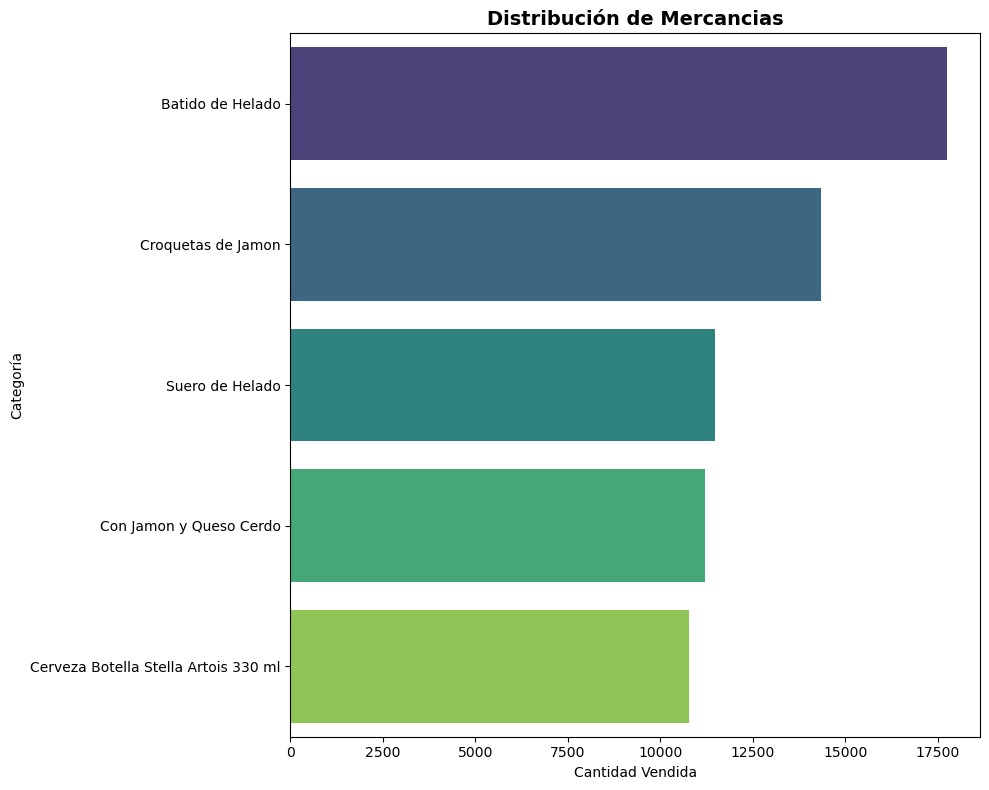

In [7]:
df_top_category = df_hystoric.groupby('mercancia', as_index=False).agg({'cantidad':'sum'}).sort_values(by='cantidad', ascending=False).head(5)

plt.figure(figsize=(10, 8))
sns.barplot(data=df_top_category, x='cantidad', y='mercancia', palette='viridis')
plt.title('Distribución de Mercancias', fontsize=14, fontweight='bold')
plt.xlabel('Cantidad Vendida')
plt.ylabel('Categoría')
plt.tight_layout()
plt.show()

Resultados:
- Como es observable en el Top 5 de las categorías más vendidas se encuetnra Insumos que no representa valor de análisis para pronósticar.
- Por la importancia que representan se analizarán las tres primeras categorías, a modo de demostración. Quedando sujeto a la decisión del cliente cuales serían las categorías de interés para predecir su demanda.

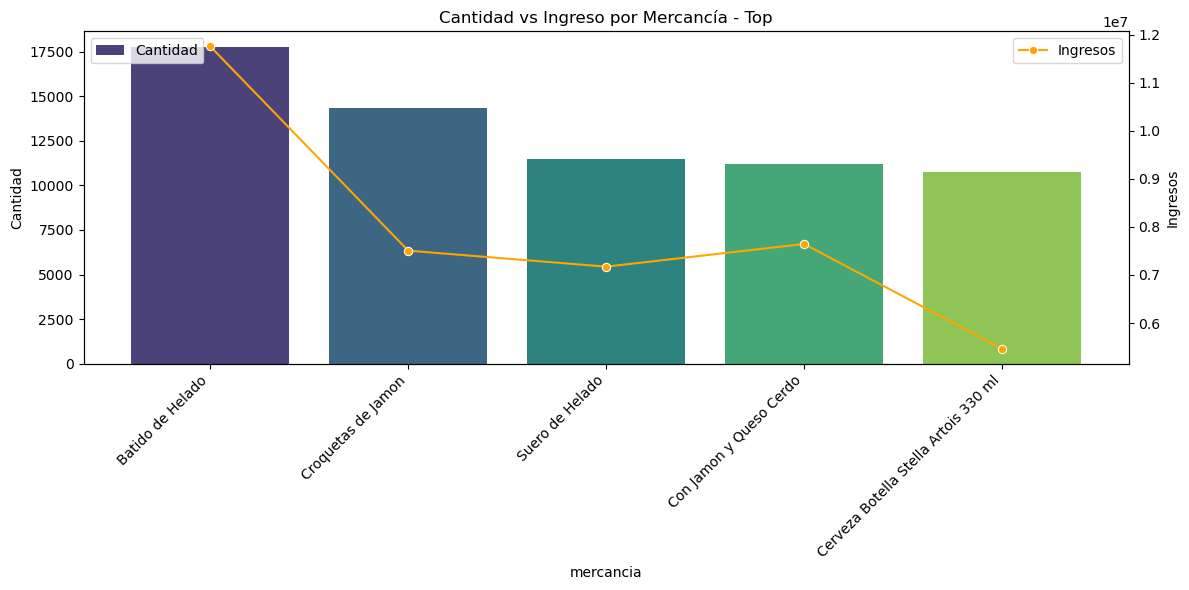

In [8]:
df_agg = df_hystoric.groupby('mercancia', as_index=False).agg({
    'cantidad': 'sum',
    'suma_total': 'sum'
})

top = df_agg.sort_values(by='cantidad', ascending=False).head(5)

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(data=top, x='mercancia', y='cantidad', ax=ax1, palette='viridis', label='Cantidad')
ax1.set_ylabel('Cantidad')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

ax2 = ax1.twinx()
sns.lineplot(data=top, x='mercancia', y='suma_total', ax=ax2, color='orange', marker='o', label='Ingresos')
ax2.set_ylabel('Ingresos')

plt.title('Cantidad vs Ingreso por Mercancía - Top')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

Resultados:
- El resultado corrobora la afirmación anterior, que las "Croquetas de Jamón" son las que mayor frequencia piden los usuarios por ticket, pero no la de mayor cantidad por pedidos. 

#### **4. Análisis Exploratorio de la Serie de Tiempo.**

**4.1. Analizando el producto con 2do mayor impacto. Croquetas de Jamon**

4.1.1. Seleccionando Croquetas de Jamon

In [9]:
df_top_producto = df_hystoric[df_hystoric["mercancia"]=="Suero de Helado"]
df_top_producto.head()

,operacion,fecha,mercancia,grupo_mercancia,nombre_socio,cantidad,medida,precio_venta,importe,suma_total,dia_semana,tipo_dia,nombre_festivo,es_fin_semana,es_festivo
48,4660,2023-07-04 17:47:00,Suero de Helado,BATIDOS,Cliente2,2.0,U,335.0,670.0,670.0,Martes,Laborable,No Festivo,0,0
57,4664,2023-07-04 18:16:00,Suero de Helado,BATIDOS,Cliente2,2.0,U,335.0,670.0,670.0,Martes,Laborable,No Festivo,0,0
72,4668,2023-07-04 18:34:00,Suero de Helado,BATIDOS,Cliente2,3.0,U,335.0,1005.0,1005.0,Martes,Laborable,No Festivo,0,0
118,4692,2023-07-04 20:31:00,Suero de Helado,BATIDOS,Cliente2,2.0,U,335.0,670.0,670.0,Martes,Laborable,No Festivo,0,0
125,4695,2023-07-04 20:39:00,Suero de Helado,BATIDOS,Cliente2,1.0,U,335.0,335.0,335.0,Martes,Laborable,No Festivo,0,0


4.1.2. Representando la Serie Temporal con variables exógenas.

In [10]:
df_top_producto = df_top_producto.groupby(df_top_producto["fecha"].dt.floor('D'), as_index=True).agg({
    'cantidad': 'sum',
    'es_festivo': 'max',
    'es_fin_semana': 'max',      
})
df_top_producto

,cantidad,es_festivo,es_fin_semana
fecha,,,
2023-07-04,19.0,0,0
2023-07-05,29.0,0,0
2023-07-06,45.0,0,0
2023-07-07,52.0,0,0
2023-07-08,74.0,0,1
...,...,...,...
2025-02-24,4.0,0,0
2025-02-25,24.0,0,0
2025-02-26,7.0,0,0


NOTA: Se realiza análisis diario ya que se intentó realiar semanal pero da muy pocos resultados aproximadamente 70 vaores a partir del pequeño tamaño del dataset. Además que aprovecha las ventajas de algunos modelos que permiten ajustar estacionalidad

In [11]:
# Suavisando con Media Móvil en un período semanal. 
nivel_suavizado = df_top_producto['cantidad'].rolling(window=7, center=True).mean()
media_general = df_top_producto['cantidad'].mean()

fig = px.line(df_top_producto, x=df_top_producto.index, y='cantidad', title='Ventas Croquetas de Suero de Helado Semanal',  labels={'cantidad': 'Ventas Diarias'})
fig.add_scatter(x=df_top_producto.index, y=nivel_suavizado, mode='lines', name='Suavizado (7 días)', line=dict(color='red'))
fig.add_trace(go.Scatter(x=[df_top_producto.index.min(), df_top_producto.index.max()], y=[media_general, media_general], mode='lines', name=f"Media general ({media_general:.2f})", line=dict(color='green', dash='dash')))
fig.show()

Resultados:

Las ventas diarias de batidos de helado son altamente variables, pero el suavizado semanal revela que no hay una tendencia de crecimiento o decrecimiento sostenido. La estabilidad de la media y la tendencia suavizada sugiere que, salvo variaciones puntuales, el negocio mantiene una demanda constante a lo largo del tiempo, permitiendo planificación operativa con base en la media semanal.


4.1.3. Descomposición estacional de la serie. STL

In [12]:
def stl_descomposition(df_category, name):
    descomp_stl = STL(df_category['cantidad'], period=7).fit()

    fig_stl = descomp_stl.plot()
    fig_stl.set_size_inches(15, 10)
    plt.suptitle(f"Descomposición de la serie {name} - Cantidad", fontsize=16)
    plt.show()
    
    return descomp_stl

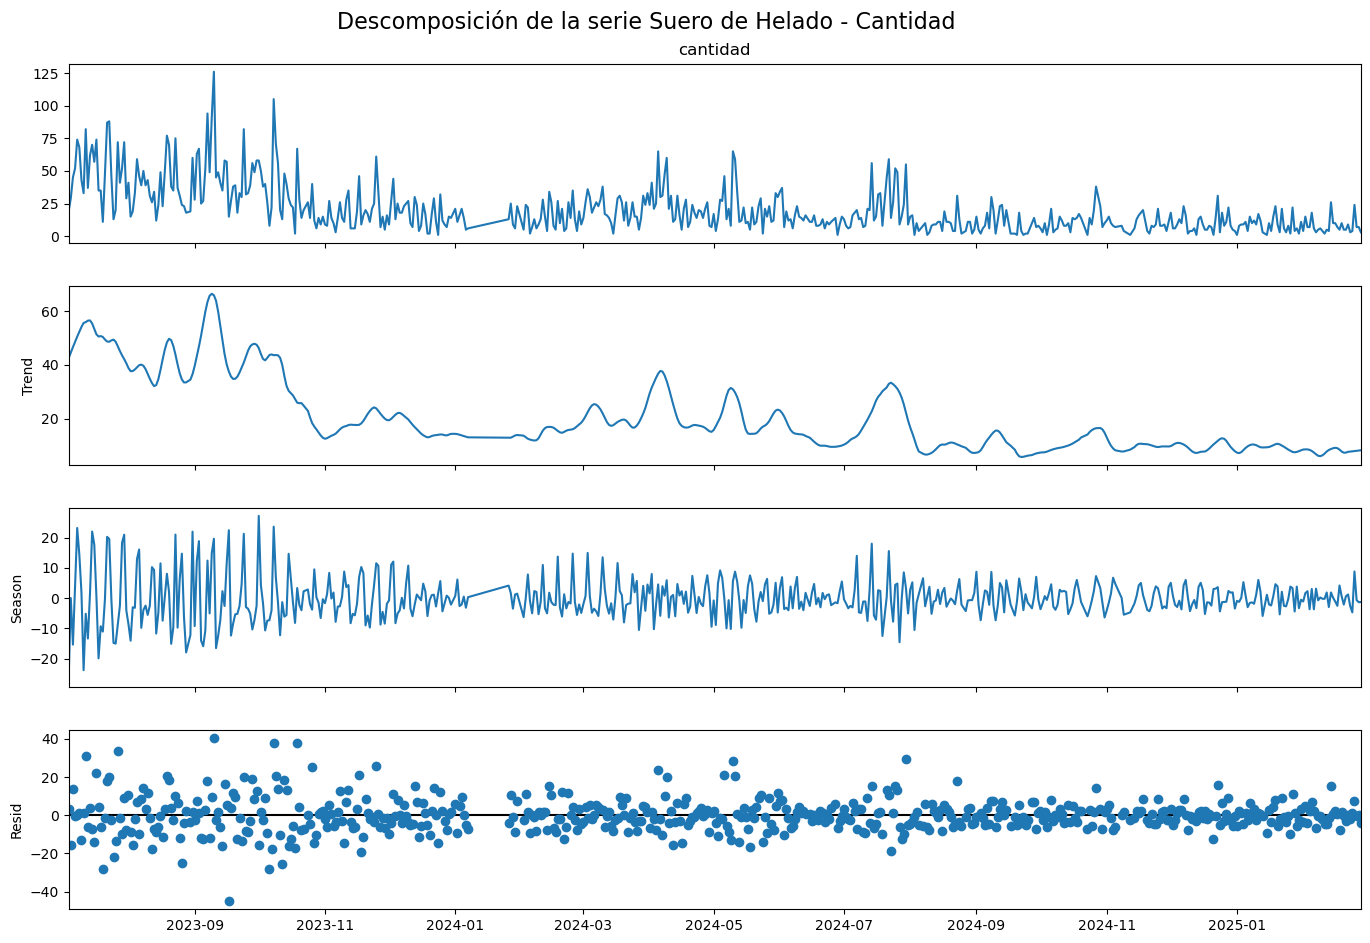

In [13]:
stl_descomp = stl_descomposition(df_top_producto, "Suero de Helado")

4.1.4. Validación Estadística de la Descomposición STL

4.1.4.1 Análisis del Componente Tendencia. Prueba Mann-Kendall (Tendencia constante).

In [14]:
def trend_component(stl_desc):
    resultado_trend = mk.original_test(stl_desc.trend.dropna())
    print(resultado_trend)

In [15]:
trend_component(stl_descomp)

Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-21.827069370432035, Tau=-0.6140839766522312, s=-97842.0, var_s=20093283.333333332, slope=-0.05008533841021501, intercept=29.680531389501123)


1.1.11. Análisis del Componente Estacionalidad. Prueba Kruskal-Wallis (Estacionalidad significativa por grupos)**

In [16]:
def seasonal_component(df_category, stl_desc):
    df_kruskal = df_category.copy()
    df_kruskal['dia_semana'] = df_category.index.dayofweek 

    grupos = [stl_desc.seasonal[df_kruskal['dia_semana'] == d].values for d in range(7)]

    stat, p_kw = kruskal(*grupos)
    print(f"Kruskal-Wallis p-value: {p_kw}")

In [17]:
seasonal_component(df_top_producto, stl_descomp)

Kruskal-Wallis p-value: 3.405023035216604e-29


**4.3.3. Análisis del Componente Residuos. Ljung-Box (Autocorrelación de residuos)**

_=> Hipótesis Nula(Ho): No existe autocorrelación entre los residuos. (Los residuos son ruido blanco)_

In [18]:
def resid_component(stl_desc):
    # Se utilizan retardos de una semana y multiplos de 7.
    ljungbox = acorr_ljungbox(stl_desc.resid.dropna(), lags=[7, 14, 21, 28], return_df=True)
    print(ljungbox)

In [19]:
resid_component(stl_descomp)

       lb_stat     lb_pvalue
7   242.126275  1.311860e-48
14  273.546040  3.786471e-50
21  277.491125  1.177262e-46
28  288.523207  4.606298e-45


**4.3. Análisis de Autocorrelaciones**

In [20]:
def autocorr_analisys(df_category):
    plot_acf(df_category['cantidad'].dropna(), lags=28)
    plt.title('Autocorrelación de la serie')
    plt.show()

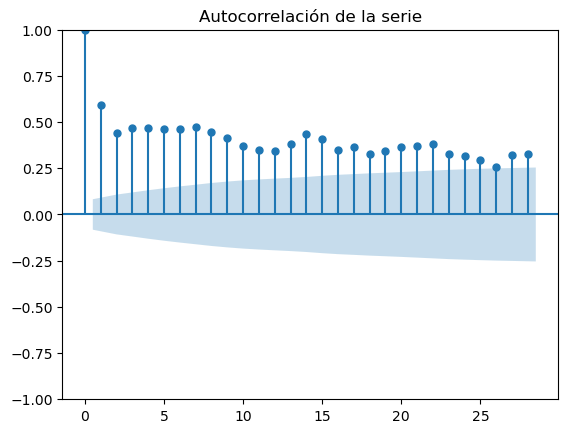

In [21]:
autocorr_analisys(df_top_producto)

**4.4. Prueba de Estacionariedad. Prueba de Dickey-Fuller Aumentada (Raíz unitaria)**

_=> Hipótesis Nula(Ho): No es estacionaria. (Tiene una raíz unitaria)_

In [22]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(df_category):
    resultado_adf = adfuller(df_category['cantidad'].dropna())  # importante eliminar NaNs

    # Mostrar resultados
    print('ADF Statistic:', resultado_adf[0])
    print('p-value:', resultado_adf[1])
    print('Valores críticos:')
    for clave, valor in resultado_adf[4].items():
        print(f'   {clave}: {valor}')

In [23]:
adfuller_test(df_top_producto)

ADF Statistic: -3.137697002085019
p-value: 0.023886328907191206
Valores críticos:
   1%: -3.442273822587951
   5%: -2.8667997388278583
   10%: -2.5695712667942465


Resultados Generales:
- La serie muestra una tendencia creciente a lo largo del periodo analizado, con incrementos más claros en la segunda mitad del año 2024.
- Se observa una marcada estacionalidad semanal, con patrones de subida y bajada recurrentes, alineados con el comportamiento típico de productos de consumo estacional.
- El componente residual no presenta patrones claros, pero muestra cierta dispersión, indicando la presencia de factores aleatorios no capturados por la tendencia ni la estacionalidad.
- El gráfico de autocorrelación revela que existen correlaciones significativas en lags semanales (multiplicidad en los picos positivos), lo que confirma la presencia de estacionalidad semanal en la serie.
- Cómo muestra el test de Man-Kendall existe una tendencia creciente estadísticamente significativa en las ventas, respaldada por un p-valor de 0.0 y un estadístico z positivo elevado.
- El test de Kruskal-Wallis, arrojó que se rechaza la hipótesis de igualdad de medianas, lo que indica que existen diferencias estadísticamente significativas entre los grupos analizados (posiblemente semanas o meses).
- El test de Ljon-Box, a partir de los bajos p-values en todos los lags confirman que los residuos no son ruido blanco, hay correlación temporal remanente, probablemente por la estacionalidad semanal.
- La serie presenta una tendencia creciente y una fuerte estacionalidad semanal.
- Existe autocorrelación y dependencia temporal significativa.
- Los residuos muestran estructura, por lo que un modelo ARIMA o SARIMA podría ajustarse adecuadamente.




#### **5. Construcción del Modelo predictivo.**

In [24]:
# Creando train y test.
df_train = df_top_producto[df_top_producto.index < '2024-11-30']
df_test = df_top_producto[df_top_producto.index >= '2024-12-01']


# Obtención de las variables exógenas
exog_train = df_train[['es_festivo', 'es_fin_semana']]
exog_test = df_test[['es_festivo', 'es_fin_semana']]


**5.1.1. Modelo STL+SARIMAX**

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Descomposición STL sobre el set de entrenamiento. 
# A partir de los resultados del análisis que demuestran una etacionadlidad semanal se selecciona un período de 7 días.
stl = STL(df_train['cantidad'], period=7)
stl_result = stl.fit()

# Extraer componentes de la Serie
trend = stl_result.trend
seasonal = stl_result.seasonal
resid = stl_result.resid

# Alinear residuos y variables exógenas
resid_model = resid.dropna()
exog_model = exog_train.loc[resid_model.index]


# Crea el modelo SARIMAX sobre los residuos.
model_stl_smx = SARIMAX(resid_model, exog=exog_model, order=(3, 0, 3), enforce_stationarity=False)
model_stl_sarimax = model_stl_smx.fit(disp=False)

n_test = len(exog_test)
forecast_resid = model_stl_sarimax.forecast(steps=n_test, exog=exog_test)

trend_forecast = np.repeat(trend.iloc[-1], n_test)
# Estacionalidad: repite el patrón semanal sobre el periodo de test
seasonal_pattern = seasonal[-7:].values  # último patrón semanal
seasonal_test = np.tile(seasonal_pattern, int(np.ceil(n_test / 7)))[:n_test]

# Reconstruye la serie predicha
forecast_stl_sarimax = trend_forecast + seasonal_test + forecast_resid.values
forecast_stl_sarimax = pd.Series(forecast_stl_sarimax, index=df_test.index, name='predicho')


actual = df_test['cantidad']
rmse_stl_smx = np.sqrt(mean_squared_error(actual, forecast_stl_sarimax))
mae_stl_smx = mean_absolute_error(actual, forecast_stl_sarimax)
mape_stl_smx = np.mean(np.abs((actual - forecast_stl_sarimax) / actual)) * 100
r2_stl_sarimax = r2_score(actual, forecast_stl_sarimax)
print(f"STL+SARIMAX: RMSE: {rmse_stl_smx:.2f}, MAE: {mae_stl_smx:.2f}, MAPE: {mape_stl_smx}, R2: {r2_stl_sarimax: .4f}, RMSE Relative: { rmse_stl_smx/np.mean(forecast_stl_sarimax) }")


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



STL+SARIMAX: RMSE: 8.30, MAE: 6.61, MAPE: 139.83955561657538, R2: -0.6850, RMSE Relative: 0.86431070684102


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



**5.1.2. SARIMAX**

In [26]:
model_smx = SARIMAX(
    df_train['cantidad'],
    exog=exog_train,
    order=(3,0,3),
    seasonal_order=(1,0,1,7),
    enforce_stationarity=False
)
fit_smx = model_smx.fit(disp=False)

# Predicción para el periodo de test
forecast_smx = fit_smx.forecast(steps=len(df_test), exog=exog_test)

# Alinear las predicciones al índice de fechas del test
forecast_smx = pd.Series(forecast_smx.values, index=df_test.index, name='predicho')

actual_smx = df_test['cantidad']

rmse_smx = np.sqrt(mean_squared_error(actual_smx, forecast_smx))
mae_smx = mean_absolute_error(actual_smx, forecast_smx)
mape_smx = np.mean(np.abs((actual_smx - forecast_smx) / actual_smx)) * 100
r2_sarimax = r2_score(actual_smx, forecast_smx)
print(f"SARIMAX Directo: RMSE: {rmse_smx:.2f}, MAE: {mae_smx:.2f}, MAPE: {mape_smx:.2f}, R2:{r2_sarimax:.4f}, RMSE Relative: { rmse_smx/np.mean(forecast_smx) }")


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMAX Directo: RMSE: 8.66, MAE: 5.82, MAPE: 121.78, R2:-0.8354, RMSE Relative: 1.0730212200822202


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



**5.1.3. PROPHET**

In [27]:
from prophet import Prophet

# Se ajusta el train/set debido a que requiere que las columnas sean [ds,y]
train_prophet = df_train.reset_index().rename(columns={'fecha':'ds', 'cantidad':'y'})
test_prophet = df_test.reset_index().rename(columns={'fecha':'ds', 'cantidad':'y'})

# Crear modelo con estacionalidad diaria
model_prophet = Prophet(
    weekly_seasonality=True,
    daily_seasonality=False,
    yearly_seasonality=False)

# Agregar variables exógenas como regresores
model_prophet.add_regressor('es_festivo')
model_prophet.add_regressor('es_fin_semana')

model_prophet.fit(train_prophet)

future = test_prophet[['ds', 'es_festivo', 'es_fin_semana']]
forecast = model_prophet.predict(future)

actual_prophet = df_test['cantidad'].values
forecast_prophet = forecast['yhat'].values

rmse_prophet = np.sqrt(mean_squared_error(actual_prophet, forecast_prophet))
mae_prophet = mean_absolute_error(actual_prophet, forecast_prophet)
mape_prophet = np.mean(np.abs((actual_prophet - forecast_prophet) / actual_prophet)) * 100
r2_prophet = r2_score(actual_prophet, forecast_prophet)
print(f"PROPHET: RMSE: {rmse_prophet:.2f}, MAE: {mae_prophet:.2f}, MAPE: {mape_prophet:.2f}, R2: {r2_prophet:.4f}, RMSE Relative: { rmse_prophet/np.mean(forecast_prophet) }")


03:01:39 - cmdstanpy - INFO - Chain [1] start processing
03:01:39 - cmdstanpy - INFO - Chain [1] done processing


PROPHET: RMSE: 6.89, MAE: 4.72, MAPE: 95.30, R2: -0.1626, RMSE Relative: 0.8311724219868375


Resultados:
- STL+SARIMAX:Presenta un error moderado (RMSE/MAE) y el mayor MAPE del grupo, con un R² negativo que indica bajo poder explicativo sobre la varianza de la serie. Su RMSE relativo es intermedio.
- SARIMAX Directo:RMSE más alto que STL+SARIMAX, pero mejor MAE. Sin embargo, su RMSE relativo es el peor del grupo y el R² es el más negativo, reflejando la peor capacidad explicativa de los tres modelos.
- PROPHET:Es el modelo con mejor desempeño general:
    - Menor RMSE, MAE y RMSE relativo.
    - MAPE considerablemente más bajo, lo que indica mejor ajuste porcentual.
    - Aunque el R² sigue siendo negativo, es el menos alejado de cero, lo que refleja un menor error respecto a la media histórica.
- El modelo Prophet es el más robusto y recomendable para la predicción de esta serie temporal:
    - Presenta menor error absoluto y relativo (RMSE, MAE, RMSE Relative).
    - Mejora considerablemente el ajuste porcentual (MAPE).
    - Aunque ningún modelo obtiene R² positivo, Prophet minimiza el error en términos relativos y absolutos, demostrando mayor capacidad para seguir la tendencia y estacionalidad.

**5.2. Ajuste de Hiperparámetros y Afinamiento del modelo.**

In [28]:
param_grid = {  
    'changepoint_prior_scale': [0.01,  0.1, 0.5], # Controla la flexibilidad del modelo para capturar cambios bruscos en la tendencia.
    'seasonality_prior_scale': [1.0, 5.0, 10.0], # Controla la flexibilidad para ajustar los patrones estacionales.
    'holidays_prior_scale': [1.0, 10.0, 20.0], # Controla cuánto permite el modelo ajustar el efecto de los festivos. 
    'seasonality_mode': ['additive', 'multiplicative']
}

# Genera todas las combinaciones
results = []
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

for params in all_params:
    model = Prophet(
        weekly_seasonality=True,
        daily_seasonality=False,
        yearly_seasonality=False,
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        seasonality_mode=params['seasonality_mode'],
    )
    model.add_regressor('es_festivo')
    model.add_regressor('es_fin_semana')
    model.fit(train_prophet)
    
    # Predicciones en train
    future_train = train_prophet[['ds', 'es_festivo', 'es_fin_semana']]
    forecast_train = model.predict(future_train)
    actual_train = train_prophet['y'].values
    pred_train = forecast_train['yhat'].values
    
    rmse_train = np.sqrt(mean_squared_error(actual_train, pred_train))
    mae_train = mean_absolute_error(actual_train, pred_train)
    mape_train = np.mean(np.abs((actual_train - pred_train) / actual_train)) * 100
    r2_train = r2_score(actual_train, pred_train)
    
    # Predicciones en test
    future_test = test_prophet[['ds', 'es_festivo', 'es_fin_semana']]
    forecast_test = model.predict(future_test)
    actual_test = test_prophet['y'].values
    pred_test = forecast_test['yhat'].values
    
    rmse_test = np.sqrt(mean_squared_error(actual_test, pred_test))
    mae_test = mean_absolute_error(actual_test, pred_test)
    mape_test = np.mean(np.abs((actual_test - pred_test) / actual_test)) * 100
    r2_test = r2_score(actual_test, pred_test)
    
    results.append({
                'changepoint_prior_scale': params['changepoint_prior_scale'],
                'seasonality_mode': params['seasonality_mode'],
                'holidays_prior_scale': params['holidays_prior_scale'],
                'rmse_train': rmse_train,
                'mae_train': mae_train,
                'mape_train': mape_train,
                'r2_train': r2_train,
                'rmse_test': rmse_test,
                'mae_test': mae_test,
                'mape_test': mape_test,
                'r2_test': r2_test
            })

03:11:21 - cmdstanpy - INFO - Chain [1] start processing
03:11:21 - cmdstanpy - INFO - Chain [1] done processing
03:11:22 - cmdstanpy - INFO - Chain [1] start processing
03:11:22 - cmdstanpy - INFO - Chain [1] done processing
03:11:22 - cmdstanpy - INFO - Chain [1] start processing
03:11:22 - cmdstanpy - INFO - Chain [1] done processing
03:11:22 - cmdstanpy - INFO - Chain [1] start processing
03:11:22 - cmdstanpy - INFO - Chain [1] done processing
03:11:22 - cmdstanpy - INFO - Chain [1] start processing
03:11:22 - cmdstanpy - INFO - Chain [1] done processing
03:11:23 - cmdstanpy - INFO - Chain [1] start processing
03:11:23 - cmdstanpy - INFO - Chain [1] done processing
03:11:23 - cmdstanpy - INFO - Chain [1] start processing
03:11:23 - cmdstanpy - INFO - Chain [1] done processing
03:11:23 - cmdstanpy - INFO - Chain [1] start processing
03:11:23 - cmdstanpy - INFO - Chain [1] done processing
03:11:23 - cmdstanpy - INFO - Chain [1] start processing
03:11:23 - cmdstanpy - INFO - Chain [1]

In [29]:
df_results = pd.DataFrame(results)
best_row = df_results.sort_values('rmse_test').iloc[0]
print("\nMejor configuración:", best_row)

# Construir modelo con mejores hiperparámetros
m_cv = Prophet(
    weekly_seasonality=True,
    daily_seasonality=False,
    yearly_seasonality=False,
    changepoint_prior_scale=best_row['changepoint_prior_scale'],
    seasonality_prior_scale=5.0,
    holidays_prior_scale=best_row['holidays_prior_scale'],
    seasonality_mode=best_row['seasonality_mode']
)
m_cv.add_regressor('es_festivo')
m_cv.add_regressor('es_fin_semana')
m_cv.fit(train_prophet)

df_cv = cross_validation(
    m_cv,
    initial='365 days',   # Usa un año para entrenar antes del primer corte
    period='30 days',     # Cada 30 días hace un nuevo split
    horizon='60 days',    # Evalúa el rendimiento a 60 días en el futuro
    parallel="processes"
)
df_pfm = performance_metrics(df_cv)
print(df_pfm[['horizon', 'mae', 'rmse', 'mape', 'coverage']].head())


03:12:07 - cmdstanpy - INFO - Chain [1] start processing



Mejor configuración: changepoint_prior_scale               0.5
seasonality_mode           multiplicative
holidays_prior_scale                 10.0
rmse_train                      13.241199
mae_train                        9.297856
mape_train                      92.176996
r2_train                         0.513327
rmse_test                        6.254294
mae_test                         4.715998
mape_test                      112.185447
r2_test                          0.043251
Name: 51, dtype: object


03:12:08 - cmdstanpy - INFO - Chain [1] done processing


  horizon       mae       rmse      mape  coverage
0  6 days  7.665922  10.157716  2.939374  0.875000
1  7 days  8.054743   9.977689  2.584989  0.895833
2  8 days  8.275546  10.048263  2.616520  0.895833
3  9 days  8.683693  10.774859  2.663507  0.875000
4 10 days  9.663951  11.826308  2.567794  0.812500


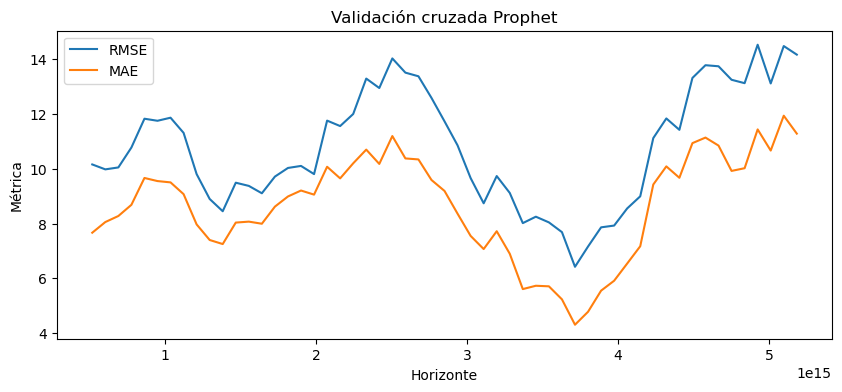

In [30]:
plt.figure(figsize=(10, 4))
plt.plot(df_pfm['horizon'], df_pfm['rmse'], label='RMSE')
plt.plot(df_pfm['horizon'], df_pfm['mae'], label='MAE')
# plt.plot(df_pfm['horizon'], df_pfm['mape'], label='MAPE')
plt.xlabel('Horizonte')
plt.ylabel('Métrica')
plt.title('Validación cruzada Prophet')
plt.legend()
plt.show()

In [32]:
print("Ajuste Vs Entrenamiento directo")
print(f"Ajuste RMSE: {df_pfm['rmse'].values[0]} -- Directo RMSE: {rmse_prophet:.2f}")
print(f"Ajuste : {df_pfm['mae'].values[0]} -- Directo RMSE: {mae_prophet:.2f}")
print(f"Ajuste : {df_pfm['mape'].values[0]} -- Directo MAPE: {mape_prophet:.2f}")

Ajuste Vs Entrenamiento directo
Ajuste RMSE: 10.157716221027362 -- Directo RMSE: 6.89
Ajuste : 7.665922181724613 -- Directo RMSE: 4.72
Ajuste : 2.9393742358133093 -- Directo MAPE: 95.30


Las métricas muestran un mejor resultado en el modelo sin ajuste, lo que puede indicar que se usó una buena combinación y que el Ajuste de Hiperparámetros puiiera llevar otros parámetros diferentes.

Por lo que se utilizará las métricas obtenidas en el modelo directo

In [33]:
df_results = pd.DataFrame(results)
best_row_tunin = df_results.sort_values('rmse_test').iloc[0]
print("\nMejor configuración:\n", best_row)

# Construir modelo con mejores hiperparámetros
model_prophet_cv = Prophet(
    weekly_seasonality=True,
    daily_seasonality=False,
    yearly_seasonality=False
)
model_prophet_cv.add_regressor('es_festivo')
model_prophet_cv.add_regressor('es_fin_semana')
model_prophet_cv.fit(train_prophet)

df_cv = cross_validation(
    model_prophet_cv,
    initial='365 days',   # Usa un año para entrenar antes del primer corte
    period='30 days',     # Cada 30 días hace un nuevo split
    horizon='60 days',    # Evalúa el rendimiento a 60 días en el futuro
    parallel="processes"
)
df_pfm_af = performance_metrics(df_cv)
print(df_pfm_af[['horizon', 'mae', 'rmse', 'mape', 'coverage']].head())


03:13:34 - cmdstanpy - INFO - Chain [1] start processing
03:13:34 - cmdstanpy - INFO - Chain [1] done processing



Mejor configuración:
 changepoint_prior_scale               0.5
seasonality_mode           multiplicative
holidays_prior_scale                 10.0
rmse_train                      13.241199
mae_train                        9.297856
mape_train                      92.176996
r2_train                         0.513327
rmse_test                        6.254294
mae_test                         4.715998
mape_test                      112.185447
r2_test                          0.043251
Name: 51, dtype: object
  horizon       mae       rmse      mape  coverage
0  6 days  7.409489   9.404081  2.976017  0.937500
1  7 days  7.819637   9.393028  2.729818  0.958333
2  8 days  7.450367   8.832192  2.677125  1.000000
3  9 days  7.601435   9.124764  2.594840  1.000000
4 10 days  8.195272  10.091862  2.374793  0.937500


Resultados:
- La predicción directa logra menor error absoluto, pero a costa de un error relativo alto (MAPE), lo que puede distorsionar la percepción de precisión cuando los valores reales son bajos.
- El ajuste ofrece un mejor balance entre precisión absoluta y relativa, resultando más robusto para escenarios donde el error porcentual es importante.
- Los resultados por horizonte de predicción indican que el modelo mantiene consistencia y confiabilidad para predicciones de hasta 10 días.
- Priorizar el ajuste cuando el MAPE sea relevante (por ejemplo, si necesitas precisión porcentual para planificación o reportes), y utilizar la predicción directa si el objetivo es minimizar el error absoluto.

**5.3. Evaluación del modelo.**

In [34]:
model_prophet_final = Prophet(
    weekly_seasonality=True,
    daily_seasonality=False,
    yearly_seasonality=False,
)
model_prophet_final.add_regressor('es_festivo')
model_prophet_final.add_regressor('es_fin_semana')
model_prophet_final.fit(train_prophet)

# Predicción en TRAIN
future_train = train_prophet[['ds', 'es_festivo', 'es_fin_semana']]
forecast_train = model_prophet_cv.predict(future_train)

# Predicción en TEST 
future_test = test_prophet[['ds', 'es_festivo', 'es_fin_semana']]
forecast_test = model_prophet_cv.predict(future_test)

actual_train = train_prophet['y'].values
pred_train = forecast_train['yhat'].values
rmse_train = np.sqrt(mean_squared_error(actual_train, pred_train))
mae_train = mean_absolute_error(actual_train, pred_train)
mape_train = np.mean(np.abs((actual_train - pred_train) / actual_train)) * 100
r2_train = r2_score(actual_train, pred_train)

# --- Test ---
actual_test = test_prophet['y'].values
pred_test = forecast_test['yhat'].values
rmse_test = np.sqrt(mean_squared_error(actual_test, pred_test))
mae_test = mean_absolute_error(actual_test, pred_test)
mape_test = np.mean(np.abs((actual_test - pred_test) / actual_test)) * 100
r2_test = r2_score(actual_test, pred_test)

print(f"TRAIN Prophet:  MAE={mae_train:.2f}, RMSE={rmse_train:.2f}, MAPE={mape_train:.2f}, R2={r2_train:.4f}")
print(f"TEST Prophet:   MAE={mae_test:.2f}, RMSE={rmse_test:.2f}, MAPE={mape_test:.2f}, R2={r2_test:.4f}")


03:17:55 - cmdstanpy - INFO - Chain [1] start processing
03:17:55 - cmdstanpy - INFO - Chain [1] done processing


TRAIN Prophet:  MAE=10.26, RMSE=14.61, MAPE=103.96, R2=0.4074
TEST Prophet:   MAE=4.72, RMSE=6.89, MAPE=95.30, R2=-0.1626


In [35]:
fig = go.Figure()
# Real en train
fig.add_trace(go.Scatter(
    x=train_prophet['ds'], y=train_prophet['y'],
    mode='lines+markers', name='Real (Train)', line=dict(color='blue')
))
# Predicho en train
fig.add_trace(go.Scatter(
    x=forecast_train['ds'], y=forecast_train['yhat'],
    mode='lines', name='Predicho (Train)', line=dict(color='orange' )
))
# Real en test
fig.add_trace(go.Scatter(
    x=test_prophet['ds'], y=test_prophet['y'],
    mode='lines+markers', name='Real (Test)', line=dict(color='green')
))
# Predicho en test
fig.add_trace(go.Scatter(
    x=forecast_test['ds'], y=forecast_test['yhat'],
    mode='lines', name='Predicho (Test)', line=dict(color='red')
))
fig.update_layout(
    title="Prophet: Real vs Predicho en Train y Test",
    xaxis_title="Fecha", yaxis_title="Cantidad",
    legend=dict(x=0, y=1.15, orientation='h'),
    height=500
)
fig.show()

Resultados:
- En este caso, el error en test es incluso menor que en train en términos absolutos, lo que indica que el modelo no está memorizando el entrenamiento ni perdiendo capacidad predictiva en el conjunto de test.
- El R2 negativo en test, pese a que puede indicar baja capacidad explicativa fuera de muestra, no es consecuencia de sobreajuste, sino más bien de la dificultad de modelar una serie con alta dispersión y valores bajos.
- No hay evidencia de sobreajuste. Los errores absolutos y relativos son similares o incluso mejores en test respecto a train.
- El modelo Prophet predice la tendencia y estacionalidad general, pero la alta dispersión y los valores bajos o atípicos penalizan fuertemente el MAPE y el R2 en test.

#### **6. Pronóstico de la demanda para producto **Croquetas de Jamon****

In [36]:
# Extrayendo los festivos del 2025.
df_day['fecha'] = pd.to_datetime(df_day['fecha'])
df_current_year = df_day[(df_day['fecha'].dt.year == 2025) & (df_day['fecha'].dt.month > 2)]

df_current_year['es_fin_semana'] = np.where(df_current_year['tipo_dia'] == 'Fin de semana', 1, 0)
df_current_year['es_festivo'] = np.where(df_current_year['tipo_dia'] == 'Festivo', 1, 0)

df_exg = df_current_year[['es_festivo','es_fin_semana']]

# Generar fechas futuras
future_dates = pd.date_range(start=test_prophet['ds'].max() + pd.Timedelta(days=1), end='2025-12-31', freq='D')
df_future = pd.DataFrame({'ds': future_dates})
df_future['es_festivo'] = df_exg['es_festivo'].values
df_future['es_fin_semana'] = df_exg['es_fin_semana'].values

# # Predicción futura
forecast_futuro = model_prophet_cv.predict(df_future)

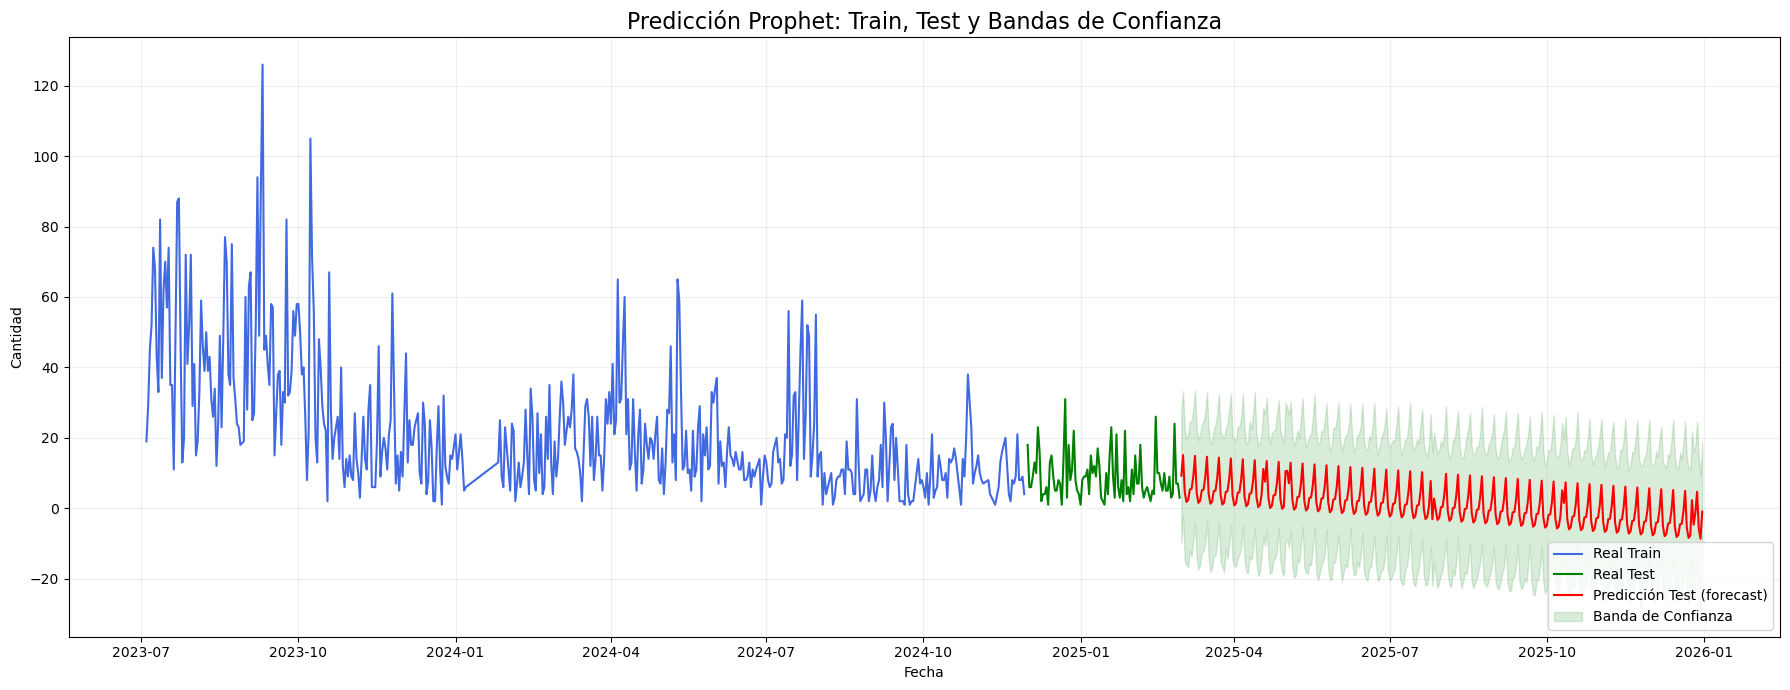

In [37]:
historico_train = train_prophet[['ds', 'y']].copy()
historico_test = test_prophet[['ds', 'y']].copy()
historico = pd.concat([historico_train, historico_test], sort=False)
historico = historico.rename(columns={'y': 'yhat'})
historico['tipo'] = 'Histórico'


forecast_futuro = forecast_futuro[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
forecast_futuro['tipo'] = 'Forecast'

df_total = pd.concat([historico, forecast_futuro], sort=False)
df_total = df_total.sort_values('ds').reset_index(drop=True)

# --- Series reales ---
plt.figure(figsize=(18, 7))
plt.plot(historico_train['ds'], historico_train['y'], color='royalblue', label='Real Train')
plt.plot(historico_test['ds'], historico_test['y'], color='green', label='Real Test')

# --- Predicciones ---
plt.plot(forecast_futuro['ds'], forecast_futuro['yhat'], color='red', label='Predicción Test (forecast)')

# # --- Banda de confianza ---
plt.fill_between(forecast_futuro['ds'], forecast_futuro['yhat_lower'], forecast_futuro['yhat_upper'],
                 color='green', alpha=0.15, label='Banda de Confianza')

# --- Estilo y leyenda ---
plt.title('Predicción Prophet: Train, Test y Bandas de Confianza', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.legend(loc='lower right')
plt.grid(alpha=0.2)
plt.tight_layout()

plt.show()

Resultados:
- El modelo Prophet captura la tendencia global y la estacionalidad de la serie, proporcionando estimaciones consistentes para la planificación general.
- El modelo no predice bien los valores extremos (picos altos y bajos), lo que es habitual en Prophet cuando se utiliza con datos muy dispersos o ruidosos.
- El intervalo de confianza crece hacia el futuro, lo que es adecuado y muestra que el modelo reconoce la menor certeza en predicciones lejanas.
- La predicción para el futuro tiende a la media histórica y a los patrones estacionales, sin anticipar valores atípicos.
- Prophet es adecuado para prever tendencia y estacionalidad general, pero no para anticipar eventos extremos.
- El comportamiento de la banda de confianza es el esperado, siendo más ancha conforme avanza el tiempo.

#### **7. Almacenamiento de Dataset de histórico y pronósticos de la demanda de BATIDOS DE HELADO.**

In [40]:
df_all = df_total[['ds','yhat']]
df_all.rename(columns={'ds': 'fecha', 'yhat': 'suero_helado'}, inplace=True)

df_all.to_csv('../data-sets/data_pronostico_producto_suero_helado.csv',index=False)